In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

main_path = os.path.realpath('')
data_path = "\\".join(main_path.split("\\")[0:-1]) + "\\pse_dane"
oze = pd.read_csv(data_path + "\\oze.csv",sep = ";",decimal = ",",na_values = "-")
wp = pd.read_csv(data_path + "\\wp.csv",sep = ";",decimal = ",")

oze.columns = ["data","godzina","gen_wiatr","gen_foto"]

wp.drop(columns=["Krajowe saldo wymiany midzysystemowej rwnolegej","Krajowe saldo wymiany midzysystemowej nierwnolegej"],inplace=True)
wp.columns = ["data","godzina","zapotrzebowanie","gen_jwcd","gen_njwcd"]
# oze.info()
# wp.info()
oze["godzina"].replace("2A","2",inplace=True)
oze["godzina"] = oze["godzina"].astype("float")
oze["godzina"] = oze["godzina"].astype("Int32")
oze["godzina"] = oze["godzina"] -1
oze["datetime"] = pd.to_datetime(oze["data"],format = "%Y-%m-%d")
oze["datetime"] = oze["datetime"] + pd.to_timedelta(oze["godzina"].astype("Int16"),unit = "h")
oze.set_index(oze["datetime"],inplace=True)
oze.drop(columns = "datetime",inplace = True)
oze.insert(0,"rok",oze.index.year)
oze.insert(1,"miesiac",oze.index.month)
oze.insert(2,"dzien",oze.index.day)


wp["godzina"].replace("2A","2",inplace=True)
wp["godzina"] = wp["godzina"].astype("float")
wp["godzina"] = wp["godzina"].astype("Int32")
wp["godzina"] = wp["godzina"] -1
wp["datetime"] = pd.to_datetime(wp["data"],format = "%Y-%m-%d")
wp["datetime"] = wp["datetime"] + pd.to_timedelta(wp["godzina"].astype("Int32"),unit = "h")
wp.set_index(wp["datetime"],inplace=True)
wp.drop(columns="datetime",inplace=True)
wp.insert(0,"rok",wp.index.year)
wp.insert(1,"miesiac",wp.index.month)
wp.insert(2,"dzien",wp.index.day)


In [2]:
##oze

In [3]:
##wp

In [4]:
def mega_to_tera(x):
    return x * 0.000001

## Roczne zapotrzebowanie, generalcja JWCD i nJWCD [TW\TWh]

In [5]:
df = wp.groupby("rok")[["zapotrzebowanie","gen_jwcd","gen_njwcd"]].sum()
df = df.applymap(mega_to_tera)


for c in df.columns.to_list():
    zmiana_c = c + "_zmiana"
    df.insert(df.columns.get_loc(c)+1,zmiana_c,df[c].diff())
    #df[zmiana_c].loc[2022] = None
df.round(2)

,zapotrzebowanie,zapotrzebowanie_zmiana,gen_jwcd,gen_jwcd_zmiana,gen_njwcd,gen_njwcd_zmiana
rok,,,,,,
2017,168.36,NaN,113.19,NaN,53.65,NaN
2018,171.01,2.65,115.49,2.31,50.54,-3.11
2019,168.92,-2.09,106.38,-9.12,53.06,2.52
2020,165.28,-3.63,98.40,-7.98,54.93,1.88
2021,174.63,9.35,118.16,19.76,56.91,1.97
2022,86.74,-87.89,56.16,-61.99,33.07,-23.84


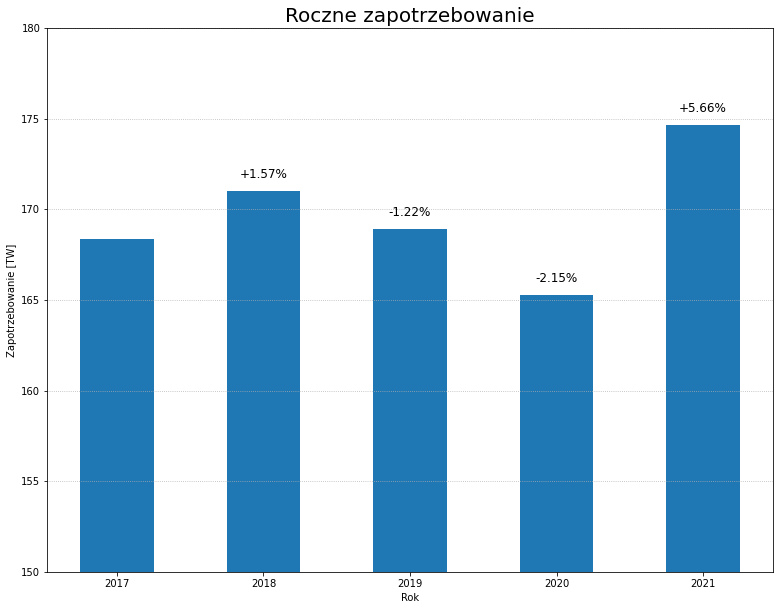

In [6]:
df = wp[wp["rok"] != 2022].groupby("rok",as_index=False)["zapotrzebowanie"].sum()
df["zapotrzebowanie"] = df["zapotrzebowanie"] *  0.000001 
df["zmiana_%"] = df['zapotrzebowanie'].pct_change() * 100
df["zapotrzebowanie"] = df["zapotrzebowanie"]  - 150
df["zmiana_%"] = df["zmiana_%"].apply(lambda x: round(x,2))
df["zmiana_%"] = df["zmiana_%"].astype("str") + "%"

df["zmiana_%"] = df["zmiana_%"].apply(lambda x: x if "-" in x else "+" + x)
df["zmiana_%"].replace("+nan%","",inplace=True)
plt.figure(figsize = (13,10) )
plt.title("Roczne zapotrzebowanie",fontdict={"size":20})
plt.xlabel("Rok")
plt.ylabel("Zapotrzebowanie [TW]")
bars= plt.bar(df["rok"],df["zapotrzebowanie"],width=0.5)
plt.xticks(df.rok)
plt.yticks(range(0,35,5),labels = [i+150 for i in range(0,35,5)])
plt.grid(axis="y",linestyle = "dotted")

plt.bar_label(bars,df["zmiana_%"],padding = 10,size = 12)

plt.show()


## Miesięczne zapotrzebowanie

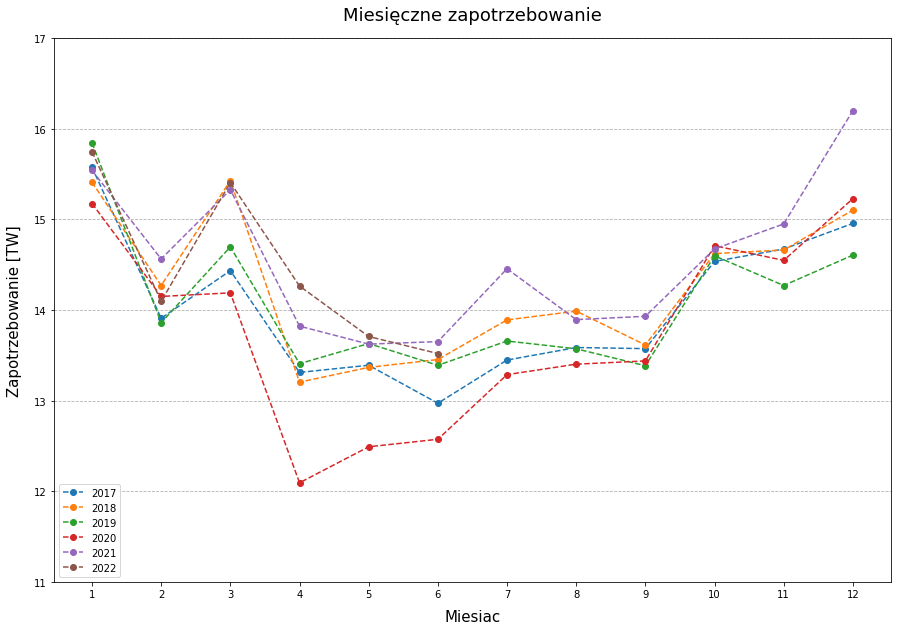

In [7]:
df = wp.groupby([wp["rok"],wp["miesiac"]],as_index=False)["zapotrzebowanie"].sum()
df["zapotrzebowanie"] = df["zapotrzebowanie"] * 0.000001
df = df.pivot(index = "miesiac",columns="rok",values="zapotrzebowanie")

plt.figure(figsize = (15,10))
plt.title("Miesięczne zapotrzebowanie",fontdict = {"fontsize": 18},pad=18)
plt.xlabel("Miesiac",labelpad=10,size = 15)
plt.ylabel("Zapotrzebowanie [TW]",labelpad=12,size = 15)

for c in df.columns:
    plt.plot(df.index,df[c].values,linestyle = "dashed",marker = "o",label=c)
plt.xticks(range(1,13))
plt.yticks(range(11,18))
plt.grid(axis = "y",linestyle = '--')
plt.legend(loc = "lower left")
plt.show()


## Godzinowe zapotrzebowanie w dniach o najwiekszym i najmiejszym zapotrzebowaniu dziennym

data
2020-04-12    301765.217
2021-12-09    579014.858
Name: zapotrzebowanie, dtype: float64


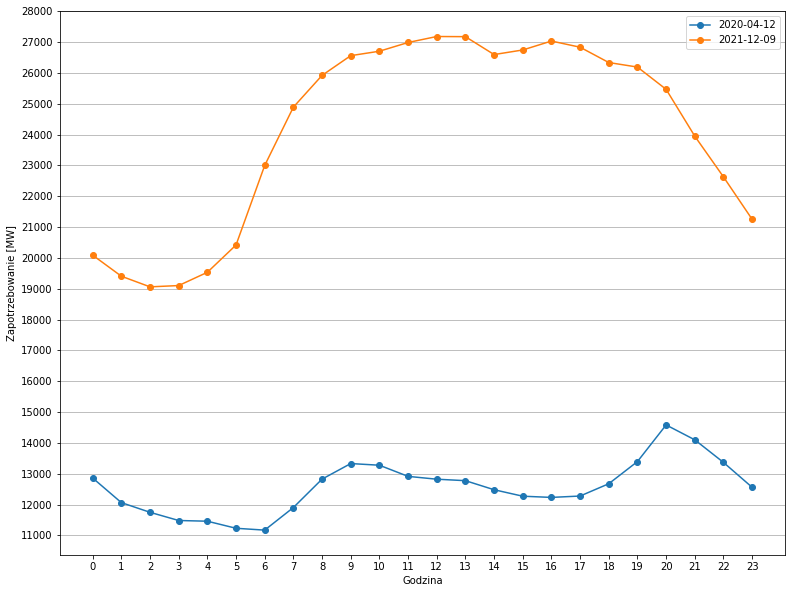

In [8]:
dt = wp.groupby("data")["zapotrzebowanie"].sum()
min = dt.nsmallest(1).index.values.tolist()[0]
max = dt.nlargest(1).index.values.tolist()[0]
df = wp[wp["data"].isin([min,max])]
print(df.groupby("data")["zapotrzebowanie"].sum())
df = df.pivot(index="godzina",columns="data",values="zapotrzebowanie")

min_y = df.min().min()
min_y = (int(min_y /1000) ) * 1000

max_y = df.max().max()
max_y = (int(max_y /1000) + 2) * 1000

plt.figure(figsize=(13,10))
plt.ylabel("Zapotrzebowanie [MW]")
plt.xlabel("Godzina")
plt.xticks(df.index.values.tolist())
for c in df.columns:
    plt.plot(df.index.values,df[c],label =c,marker = "o")

plt.yticks(range(min_y,max_y,1000))
plt.legend()
plt.grid(axis = "y")
plt.show()


## Generacja OZE

C:\Users\Maciek\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


      gen_wiatr  gen_foto
rok                      
2017  14.411846  0.000000
2018  12.325990  0.000000
2019  14.565727  0.000000
2020  15.213590  1.764725
2021  15.248797  4.614557
2022  10.545010  4.599393


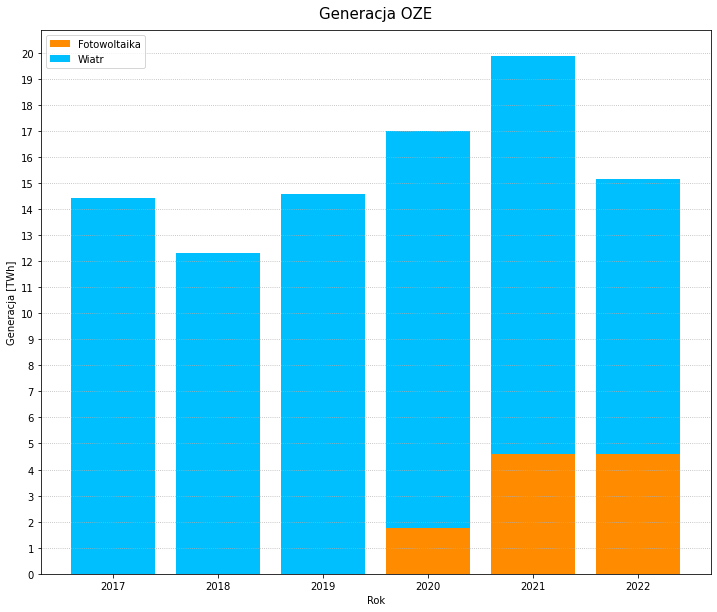

In [56]:

df = oze.groupby("rok")["gen_wiatr","gen_foto"].sum()
df = df.applymap(mega_to_tera)
print(df)
max_y = int((df["gen_wiatr"] + df["gen_foto"]).max())+2
plt.figure(figsize=(12,10))
plt.title("Generacja OZE",fontdict={"size":15},pad=12)
plt.xlabel("Rok")
plt.ylabel("Generacja [TWh]")
plt.yticks(range(0,max_y))

plt.bar(df.index.values,df["gen_foto"],color = "darkorange",label = "Fotowoltaika")
plt.bar(df.index.values,df["gen_wiatr"],color = "deepskyblue",bottom=df["gen_foto"],label="Wiatr")


plt.grid(axis="y",linestyle = "dotted")
plt.legend(loc = "upper left")
plt.show()

## Średnia godzinowa generacja farm wiatrowych

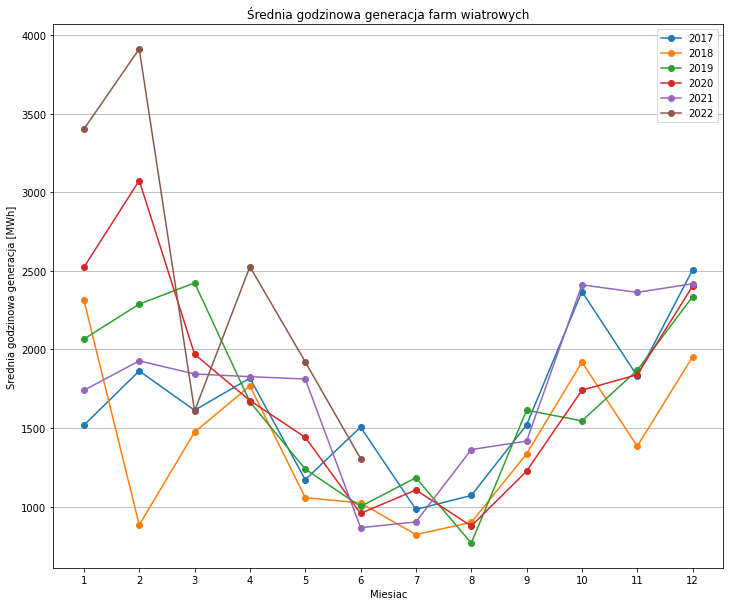

In [90]:
df = oze.groupby(["rok","miesiac"],as_index=False)["gen_wiatr"].mean()


plt.figure(figsize=(12,10))
plt.title("Średnia godzinowa generacja farm wiatrowych")
plt.xlabel("Miesiac")
plt.xticks(range(1,13))

plt.ylabel("Srednia godzinowa generacja [MWh]")

for y in df["rok"].unique():
    
    plt.plot(df[df["rok"] == y]["miesiac"],df[df["rok"] == y]["gen_wiatr"],label = y,marker="o")
plt.grid(axis="y")
plt.legend()
plt.show()

## Udziały procentowowe farm wiatrowych i fotowoltaiki w generacji OZE w 2021

gen_wiatr    15.248797
gen_foto      4.614557
dtype: float64


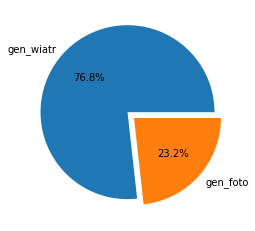

In [111]:
year = 2021
df = oze[oze["rok"] == 2021][["gen_wiatr","gen_foto"]].sum().apply(mega_to_tera)
print(df)
plt.figure(facecolor="white")
plt.pie(df.values,labels=df.index.values,explode=[0.05,0.05],autopct='%1.1f%%')
plt.show()

In [145]:
#generacja godzinowa w n top dni pod wzgledem dzienniej generacji
# days = oze.groupby("data")["gen_wiatr"].sum().nlargest(10).index.values
# oze[oze["data"].isin(days)]
# # plt.figure(figsize=(12,10))
# # plt.xlabel("Godzina")
# # plt.ylabel("Generacja [MWh]")
# # for d in days:
# #     plt.plot(range(0,24),oze[oze["data"] ==d ]["gen_wiatr"],label = d,marker = "o")

# # plt.legend()
# # plt.show()


## Mediana godzinowej generacji w 2021

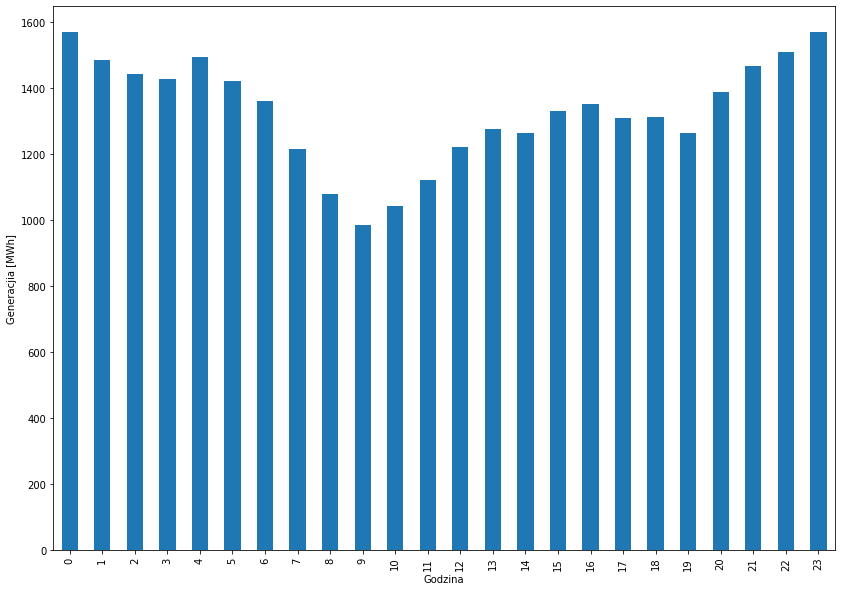

In [161]:
plt.figure(figsize=(14,10))
df = oze[oze["rok"]==2021].groupby("godzina")["gen_wiatr"].median()
#plt.stem(df.values)
df.plot(kind = "bar")
plt.xlabel("Godzina")
plt.xticks(range(0,24))

plt.ylabel("Generacjia [MWh]")

plt.show()

## Pokrycie zapotrzebowania przez OZE

In [223]:

oze["gen_oze"] = oze["gen_wiatr"] + oze["gen_foto"].fillna(0.00)

df = pd.merge(wp,oze[["gen_wiatr","gen_foto","gen_oze"]],how="left",left_index=True,right_index=True)
df["pokrycie"] = df.gen_oze / df["zapotrzebowanie"]
df["pokrycie_txt"] = (df["pokrycie"] * 100).astype("str") + "%"
#df.nlargest(columns = "pokrycie",n= 20).sort_values("data")
#df[df["rok"] == 2021].nlargest(columns = "pokrycie",n= 20).sort_values("data")


### Minimalne i maksymalne godzinowe pokrycie

In [227]:
def proc_to_txt(x):
    return str(round(x,3)*100) + "%"

df.groupby("rok")["pokrycie"].agg(
    min = ("min"),
    max = ("max")
).applymap(proc_to_txt)


,min,max
rok,,
2017,0.1%,39.7%
2018,0.1%,36.3%
2019,0.0%,36.4%
2020,0.1%,37.9%
2021,0.4%,44.3%
2022,0.2%,60.4%


### Miesieczne pokrycie

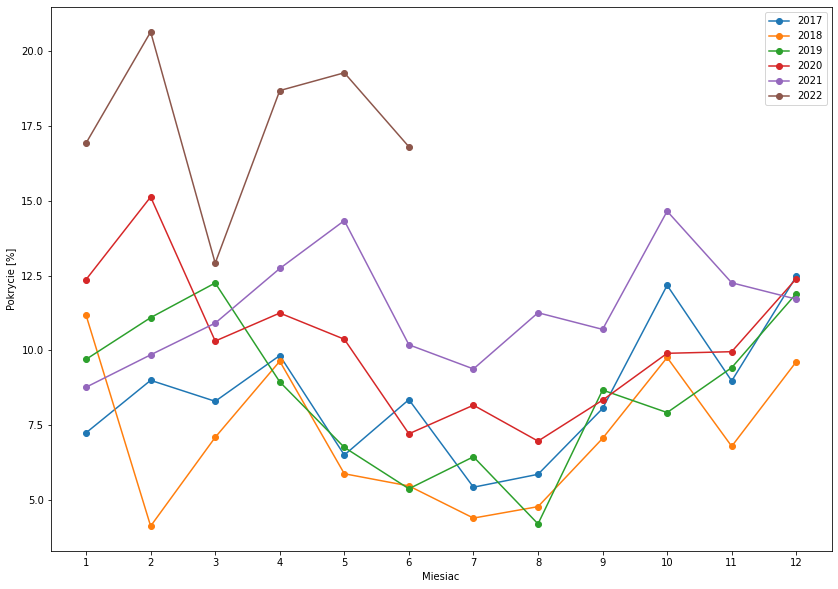

In [314]:
df = df.groupby(["rok","miesiac"],as_index=False)[["zapotrzebowanie","gen_oze"]].sum()
df["pokrycie"] = (df["gen_oze"] / df["zapotrzebowanie"])*100
plt.figure(figsize=(14,10))

plt.ylabel("Pokrycie [%]")

plt.xlabel("Miesiac")
plt.xticks(range(1,13))

for r in df["rok"].unique():
    plt.plot(df[df["rok"] ==r]["miesiac"].values,df[df["rok"] ==r]["pokrycie"],marker = "o",label = r)
plt.legend()
plt.show()


C:\Users\Maciek\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  # This is added back by InteractiveShellApp.init_path()


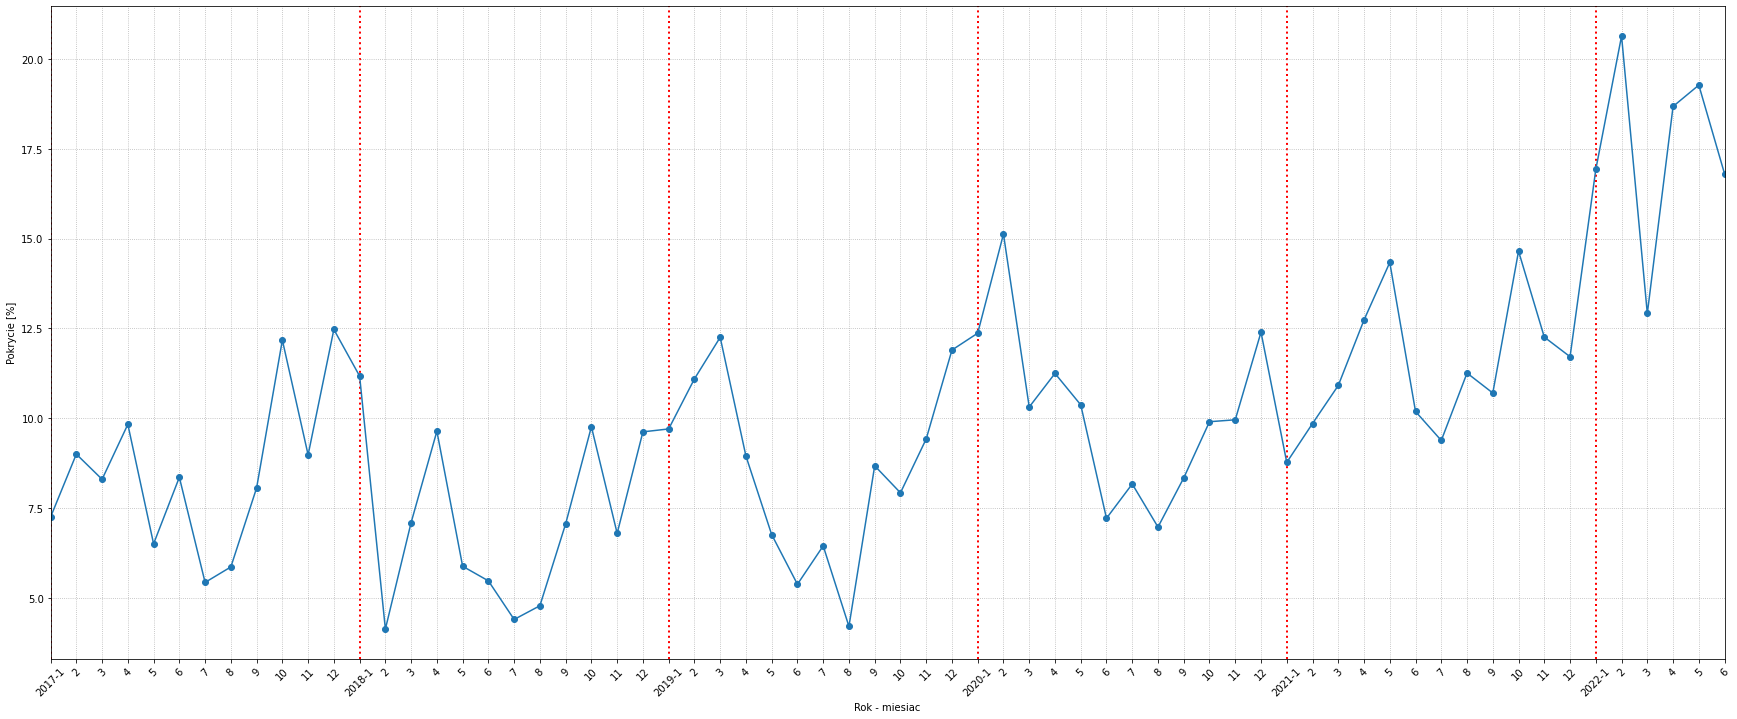

In [366]:
df["okres"] = df["rok"].astype(str) + "-" + df["miesiac"].astype(str)
xt = [ o if o[-2:] =="-1" else o.split("-")[1] for o in df["okres"]]
df["x_t"] = xt
df.set_index("x_t",inplace=True)
df["pokrycie"]

plt.figure(figsize=(30,12))
p =df["pokrycie"].plot(marker = "o")
plt.xlabel("Rok - miesiac")
plt.ylabel("Pokrycie [%]")
plt.xlim(left=1,right=1)
plt.xticks(range(0,df.shape[0]),labels=df.index.values,rotation=45)
plt.grid(linestyle ="dotted")
x_grid_lines = p.get_xgridlines()
for i,l in enumerate(x_grid_lines):
    if i % 12 ==0:
        l.set_color("red") 
        l.set_linewidth(2)
plt.show()


In [376]:
oze["delta"] = oze.gen_foto.diff()
oze.sort_values("delta").nsmallest(n=20,columns="delta")

,rok,miesiac,dzien,data,godzina,gen_wiatr,gen_foto,gen_oze,delta
datetime,,,,,,,,,
2022-06-24 18:00:00,2022,6,24,2022-06-24,18,2851.538,1695.050,4546.588,-1483.100
2022-05-18 18:00:00,2022,5,18,2022-05-18,18,314.300,1919.600,2233.900,-1455.225
2022-06-23 18:00:00,2022,6,23,2022-06-23,18,250.288,1873.000,2123.288,-1432.338
2022-06-05 18:00:00,2022,6,5,2022-06-05,18,859.613,1626.200,2485.813,-1394.688
2022-06-22 18:00:00,2022,6,22,2022-06-22,18,362.400,1808.288,2170.688,-1391.137
2022-06-29 18:00:00,2022,6,29,2022-06-29,18,340.525,1335.675,1676.200,-1372.350
2022-06-19 18:00:00,2022,6,19,2022-06-19,18,4371.225,1609.450,5980.675,-1353.450
2022-05-18 17:00:00,2022,5,18,2022-05-18,17,315.563,3374.825,3690.388,-1315.738
2022-06-17 18:00:00,2022,6,17,2022-06-17,18,775.150,1638.700,2413.850,-1295.863
